In [ ]:
import numpy as np
import cv2
from scipy.constants import c, pi
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
from scipy.ndimage import gaussian_filter1d

# uncomment for inline matlab style interactive figures
# %matplotlib widget

%cd ".."
import simulation as sim
import fft_shift as fft_shift
from utils import calculate_snr, create_mask
from fig_setup import fig_setup

fig_setup() # comment this if using matplotlib widget because they conflict

#### Useful parameters

In [2]:
# data paths and variables
save_figs = False

mod_freq = 60 # MHz
wavelength = 940 # nm
k_deg = 90
k = np.deg2rad(k_deg)
calib_offset = 0 # mm
cropX = 0
cropY = 0
gauss_dim='1d'
sigma=1
phase_variation_axis="x"

# from mlx datasheet
unambig_dist = (c*0.5)/(mod_freq *1e6)
coeff_to_rad = unambig_dist / (2 * pi)

#### Load data

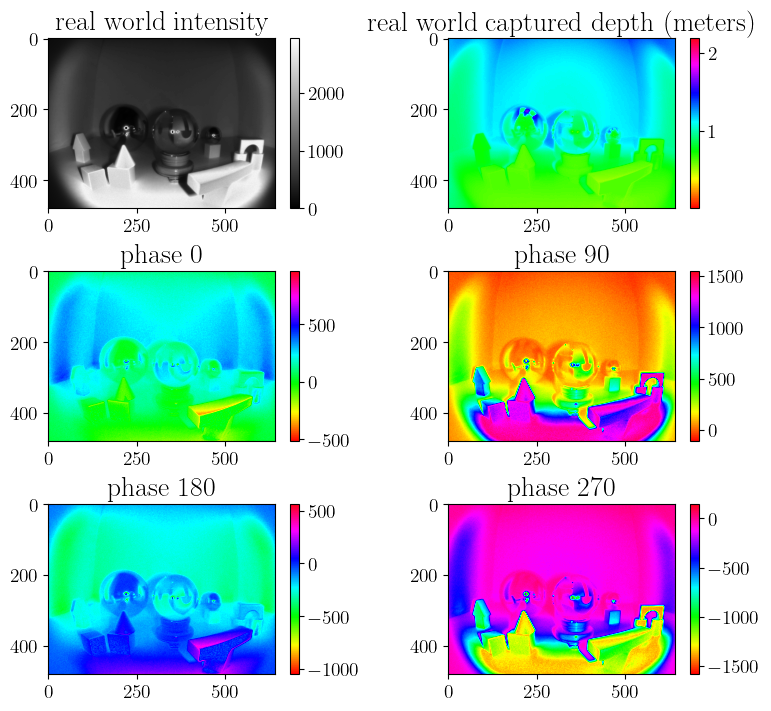

In [3]:
with np.load('data/spec_refract/dist_amp.npz') as gt_data:
    depth_rw = ((gt_data['dist'] - calib_offset) * 1e-3)[cropY:, cropX:] # divide by 1e3 to get meters
    intensity_rw = gt_data['amp'][cropY:, cropX:]
    
with np.load('data/spec_refract/phase_data.npz') as phase_data:
    I0_rw = phase_data['phase0'][cropY:, cropX:]
    I90_rw = phase_data['phase90'][cropY:, cropX:]
    I180_rw = phase_data['phase180'][cropY:, cropX:]
    I270_rw = phase_data['phase270'][cropY:, cropX:]
    
phase_rw = (depth_rw / coeff_to_rad) - pi # calculate the phase from the depth

# show the real world data
fig_rw, axs = plt.subplots(3,2, figsize=(8,7), layout="constrained")
im = axs[0,0].imshow(intensity_rw, cmap="gray")
axs[0,0].set_title("real world intensity")
fig_rw.colorbar(im, ax=axs[0,0])

im = axs[0,1].imshow(depth_rw, cmap="hsv")
axs[0,1].set_title("real world captured depth (meters)")
fig_rw.colorbar(im, ax=axs[0,1])

im = axs[1,0].imshow(I0_rw, cmap="hsv")
axs[1,0].set_title("phase 0")
fig_rw.colorbar(im, ax=axs[1,0])

im = axs[1,1].imshow(I90_rw, cmap="hsv")
axs[1,1].set_title("phase 90")
fig_rw.colorbar(im, ax=axs[1,1])

im = axs[2,0].imshow(I180_rw, cmap="hsv")
axs[2,0].set_title("phase 180")
fig_rw.colorbar(im, ax=axs[2,0])

im = axs[2,1].imshow(I270_rw, cmap="hsv")
axs[2,1].set_title("phase 270")
fig_rw.colorbar(im, ax=axs[2,1])

### Create a simulation

In [4]:
fft_shift_sim = fft_shift.FFT_Shift(k,
                                    intensity_rw, depth_rw,
                                    omega = 2.0 * pi * (mod_freq * 1e6))

# computationally create quad intensity measurements
fft_shift_sim.create_quad_intensity(method='mlx')
computed_phases = [fft_shift_sim.I0, fft_shift_sim.I90, fft_shift_sim.I180, fft_shift_sim.I270]

# compute emulated image intensity
fft_shift_sim.create_composite_intensity(phase_variation_axis=phase_variation_axis, use_Gaussian=gauss_dim, sigma=sigma, method='mlx') # computational
composite_intensity = fft_shift_sim.composite_image

# calculate the fft shift
fft_shift_sim.calculate_fft_shifted(phase_variation_axis=phase_variation_axis)

# reconstruct and scale intensity, phase, depth from fft shift
recon_intensity = 2 * fft_shift_sim.reconstruct_intensity()
recon_phase = fft_shift_sim.reconstruct_phase() - (pi/2.0)
recon_depth = ((c * (recon_phase + pi)) / (4 * pi * mod_freq * 1e6))

fft_shift_sim.get_metadata()

image width, height:  640 480
using Gaussian filtering? :  True
sigma =  1
using real world data? :  False
using quad data to calculate phase/amp? False
k =  1.5707963267948966 rad  90.0 deg


### Display results

In [7]:
intensity_conventional = 2*np.sqrt((I90_rw-I270_rw)**2 + (I0_rw - I180_rw)**2)
phase_conventional = -np.arctan2(I90_rw-I270_rw, I0_rw - I180_rw)

snr_intensity_conv = calculate_snr(intensity_rw, intensity_conventional)
snr_phase_conv = calculate_snr(phase_rw, phase_conventional)
snr_intensity_fourier = calculate_snr(intensity_rw, recon_intensity)
snr_phase_fourier = calculate_snr(phase_rw, recon_phase)

print("SNR Amp Conventional: ", snr_intensity_conv)
print("SNR Phase Conventional: ", snr_phase_conv)
print("SNR Amp Snapshot: ", snr_intensity_fourier)
print("SNR Phase Snapshot: ", snr_phase_fourier)

SNR Amp Conventional:  -16.811738737154922
SNR Phase Conventional:  28.480984865413138
SNR Amp Snapshot:  16.985706667021145
SNR Phase Snapshot:  33.46602708405656


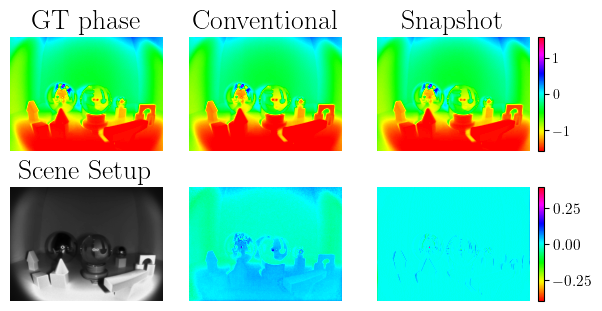

In [8]:
fig_rw, axs = plt.subplots(2,3, figsize=(6, 3), layout="constrained")

axs[0,0].axis('off')
im = axs[0,0].imshow(np.pad(phase_rw, ((cropX,0), (cropY,0)), mode='edge'), cmap="hsv", vmin=-pi/2, vmax=pi/2)
axs[0,0].set_title("GT phase")

im = axs[0,1].imshow(np.pad(phase_conventional, ((cropX,0), (cropY,0)), mode='edge'), cmap="hsv", vmin=-pi/2, vmax=pi/2)
axs[0,1].set_title("Conventional")
axs[0, 1].axis('off')

im = axs[0,2].imshow(np.pad(recon_phase, ((cropX,0), (cropY,0)), mode='edge'), cmap="hsv", vmin=-pi/2, vmax=pi/2)
axs[0,2].set_title("Snapshot")
cbar=fig_rw.colorbar(im, ax=axs[0,2])
cbar.ax.tick_params(labelsize=10) 
axs[0, 2].axis('off')

axs[1,0].axis('off')
im = axs[1,0].imshow(np.pad(intensity_rw, ((cropX,0), (cropY,0)), mode='edge'), cmap="gray", vmin=0, vmax=3000)
axs[1,0].set_title("Scene Setup")

im = axs[1,1].imshow(np.pad(phase_rw - phase_conventional, ((cropX,0), (cropY,0)), mode='edge'), cmap="hsv", vmin=-pi/8, vmax=pi/8)

axs[1,1].axis('off')

im = axs[1,2].imshow(np.pad(phase_rw - recon_phase, ((cropX,0), (cropY,0)), mode='edge'), cmap="hsv", vmin=-pi/8, vmax=pi/8)

axs[1,2].axis('off')
cbar=fig_rw.colorbar(im, ax=axs[1,2])
cbar.ax.tick_params(labelsize=11)

if save_figs:
    fig_rw.savefig("figures/CVPRfigures/robustness_local_error.pdf", bbox_inches = 'tight')